# Diffusion Generative Modelling for Simulation-Based Inference

An introduction to diffusion generative models in SBI to learn and sample from posterior distributions in the setiing of tall context data. 

In [41]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.manual_seed(1)

import sys
sys.path.append("../")

N_TRAIN = 10_000
N_SAMPLES = 4096

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## SBI Task: Simulator, Prior and True/Target Posterior 

- Prior (2D): $\lambda(\theta) = \mathcal{N}(\mu_\lambda, \Sigma_\lambda)$ with $\mu_\lambda = (0, 175)$ and $\Sigma_\lambda = \begin{pmatrix} 5^2 & 1 \\ 1 & 25^2 \end{pmatrix}$
- Simualtor (2D): $x \sim \text{Simulator}(\theta) \approx p(x\mid \theta) = \mathcal{N}(\theta, \Sigma)$ with $\Sigma = \begin{pmatrix} 1 & 0.8 \\ 0.8 & 1 \end{pmatrix}$

Goal: estimate $p(\theta\mid x^\star)$ with $x^\star$ an observation.

N.B.: the true posterior is the productoct of two Gaussians, i.e. a Gaussian $\mathcal{N}(\mu_\text{post}(x^\star), \Sigma_\text{post})$ with 
$$\mu_\text{post}(x^\star) = \Sigma_\text{post} \left(\Sigma^{-1}_\lambda\mu_\lambda + \Sigma^{-1}x^\star\right) \quad \text{and} \quad \Sigma_\text{post} = (\Sigma^{-1}_\lambda + \Sigma^{-1})^{-1}$$

In [42]:
# SBI Task: Inference of 2d Gaussian Mean under uniform prior
from tasks.toy_examples.data_generators import SBIGaussian2d

# Task
task = SBIGaussian2d(prior_type="gaussian")
# Prior and Simulator
prior = task.prior
simulator = task.simulator

# Observation
theta_true = torch.FloatTensor([-5, 150])  # true parameters
x_obs = simulator(theta_true)  # x_0 ~ simulator(theta_true)
observation = {"theta_true": theta_true, "x_obs": x_obs}

# True posterior: p(theta|x_0)
true_posterior = task.true_posterior(x_obs)

# True posterior p(theta|mean(x_1,...,x_10)), x_i ~ simulator(theta_true)
x_obs_100 = torch.cat([simulator(theta_true).reshape(1, -1) for i in range(100)], dim=0)
true_posterior_100 = task.true_posterior(torch.mean(x_obs_100, axis=0))

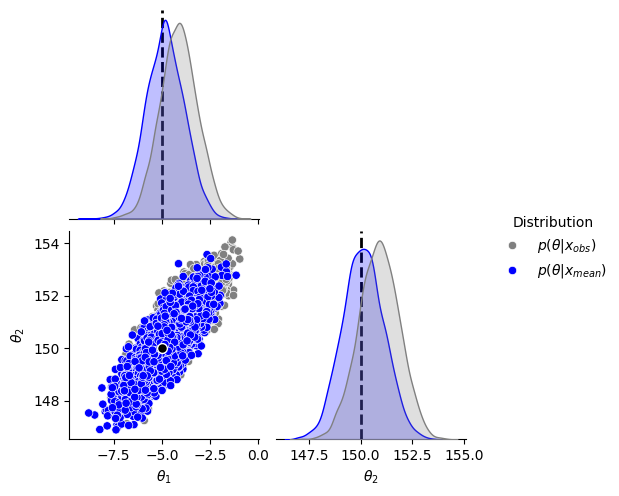

In [43]:
# Plot true posteriors: P(theta | x_obs)

from plot_utils import pairplot_with_groundtruth_2d

samples_true = true_posterior.sample((N_SAMPLES,)).numpy()
samples_true_100 = true_posterior_100.sample((N_SAMPLES,)).numpy()

pairplot_with_groundtruth_2d(
    samples_list=[samples_true, samples_true_100],
    labels=[r"$p(\theta | x_{obs})$", r"$p(\theta | x_{mean})$"],
    colors=["grey", "blue"],
    theta_true=theta_true,
    # prior_bounds=(prior.bounds[0], prior.bounds[1])
)


The simulator is stochastic, meaning that an observation $x^\star \sim p(x\mid \theta^\star)$ might not correspond to the most probable one: the posterior $p(\theta \mid x^\star) = \mathcal{N}(x^\star, \Sigma)$ is centered around $x^\star$=`x_obs` and not $\theta^\star$=`theta_true`.

In order to solve this stochasticity problem and get a posterior centered around the true parameters, we would need more than one observation simulated using the true parameter $\theta_0$ and for example compute the empirical approximation of the mean of the simulator likelihood:
$$x^\star_i \sim p(x\mid \theta^\star) = \mathcal{N}(\theta^\star,\Sigma) \rightarrow x_{mean} = \frac{1}{n}\sum x^\star_i \approx \theta^\star$$

QUESTION: will this posterior be centered around $\theta^\star$? Do the math !


## Diffusion posterior Sampling

We consider the following VP-SDE
$$\mathrm{d}\theta = f(t)\theta \mathrm{d}t + g(t)\mathrm{d}w \quad \text{with} \quad f(t) = -\frac{1}{2}\beta(t), \quad g(t) = \sqrt{\beta(t)}$$
for a given noise schedule $\beta(t)$. Any distribution $p(\theta)$ (prior and posterior) can be diffused as follows
$$p_t(\theta) = \int_0^t p(\theta_0)q_{t\mid0}(\theta\mid\theta_0)\mathrm{d}\theta_0, \quad p_0(\theta) = p(\theta)$$
for which the transition kernel is
$$q_{t\mid0}(\theta\mid\theta_0) = \mathcal{N}(\theta; \sqrt{\alpha(t)}\theta_0, \sigma^2(t)\mathbf{I}_2) \quad \text{with} \quad \alpha(t) = \exp\left(-\int_0^t \beta(s)\mathrm{d} s\right), \quad \sigma^2(t) = 1-\alpha(t).$$

Sampling from this distribution can be done by solving the reverse SDE which requires to know the Fisher score $\nabla_\theta p_t(\theta)$:
$$\mathrm{d}\theta = \Big[f(t)\theta-g^2(t)\nabla \log p_t(\theta)\Big]\mathrm{d}t + g(t)\mathrm{d}w$$

### True posterior score

Standard results on Gaussian distributions allow us to compute the exact Fisher score for the diffused true posterior
$$\nabla_\theta \log p_t(\theta \mid x^\star) = -(\alpha(t) \Sigma_\text{post} + \sigma^2(t) \mathbf{I}_2)^{-1} (\theta - \sqrt{\alpha(t)}\mu_\text{post})~.$$
We can now sample from the true posterior by solving the reverse SDE using a SDE integrator (e.g. Euler-Maruyama).

In [44]:
from tqdm import tqdm

def euler_sde_sampler(score_fn, nsamples, beta):
    theta_t = torch.randn((nsamples, 2))  # (nsamples, 2)
    time_pts = torch.linspace(1, 0, 1000)  # (ntime_pts,)
    for i in tqdm(range(len(time_pts) - 1)):
        t = time_pts[i]
        dt = time_pts[i + 1] - t

        # calculate the drift and diffusion terms
        f = -0.5 * beta(t) * theta_t
        g = beta(t) ** 0.5
        score = score_fn(theta_t, t).detach()
        drift = f - g * g * score
        diffusion = g

        # euler-maruyama step
        theta_t = theta_t + drift * dt + diffusion * torch.randn_like(theta_t) * torch.abs(dt) ** 0.5
        theta_t.detach()
    return theta_t

 16%|█▌        | 160/999 [00:00<00:00, 1593.86it/s]

100%|██████████| 999/999 [00:00<00:00, 1416.52it/s]


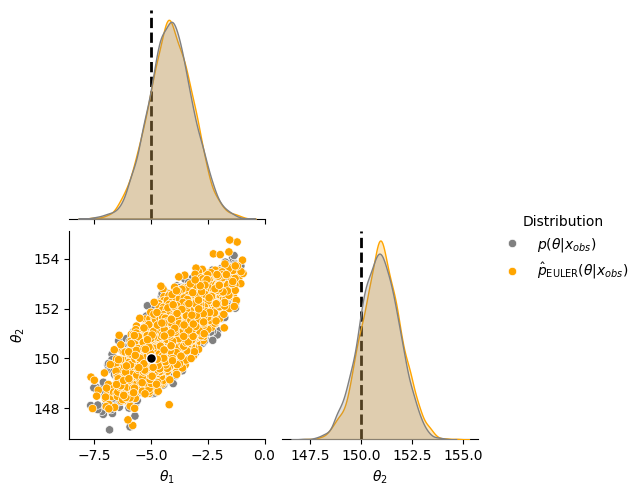

In [45]:
from vp_diffused_priors import get_vpdiff_gaussian_score
from nse import NSE
diffused_posterior_score = get_vpdiff_gaussian_score(mean=true_posterior.loc, cov=true_posterior.covariance_matrix, nse=NSE(2,2))

samples = euler_sde_sampler(diffused_posterior_score, N_SAMPLES, beta=NSE(2,2).beta)

pairplot_with_groundtruth_2d(
    samples_list=[samples_true, samples],
    labels=[r"$p(\theta | x_{obs})$", r"$\hat{p}_\text{EULER}(\theta | x_{obs})$"],
    colors=["grey", "orange"],
    theta_true=theta_true,
    # prior_bounds=(prior.bounds[0], prior.bounds[1])
)

In [46]:
# compare auto diff vs. analytic score
def vpdiff_gaussian(t, dist, nse):

        # transition kernel p_{t|0}(theta_t) = N(theta_t | mu_t, sigma^2_t I)
        # with mu_t = theta * scaling_t
        scaling_t = nse.alpha(t) ** 0.5
        sigma_t = nse.sigma(t)

        # from Bishop 2006 (2.115)
        # p_t(theta_t) = int p_{t|0}(theta_t|theta) p(theta)dtheta
        # = N(theta_t | scaling_t * mean, sigma^2_t I + scaling_t^2 * cov)
        loc=scaling_t * dist.loc
        covariance_matrix=sigma_t**2 * torch.eye(2, device=dist.loc.device) + scaling_t**2 * dist.covariance_matrix

        return torch.distributions.MultivariateNormal(loc, covariance_matrix)

theta = torch.randn((N_SAMPLES,2))
theta.requires_grad = True
t = torch.tensor([1])

# posterior score
log_posterior_t = vpdiff_gaussian(t, true_posterior, nse=NSE(2,2)).log_prob(theta)

theta.grad = None
log_posterior_t.sum().backward()

score_posterior_t_ana = diffused_posterior_score(theta, t)

print((theta.grad - score_posterior_t_ana).square().mean())

# prior score
theta.grad = None
log_prior_t = vpdiff_gaussian(t, prior.prior, nse=NSE(2,2)).log_prob(theta)
log_prior_t.sum().backward()

diffused_prior_score = get_vpdiff_gaussian_score(prior.prior.loc, prior.prior.covariance_matrix, NSE(2,2))
score_prior_t_ana = diffused_prior_score(theta, t)

print((theta.grad - score_prior_t_ana).square().mean())


tensor(1.3817e-14, grad_fn=<MeanBackward0>)
tensor(3.9378e-15, grad_fn=<MeanBackward0>)


### Sampling from the true *tall* posterior $p(\theta \mid x_{1:n})$

The tall posterior score is:
$$\nabla_\theta \log p_t(\theta \mid x^\star_{1:n}) = (1-n)\nabla_\theta \log p^\lambda_t(\theta) + \sum_{j=1}^n \nabla_\theta \log p_t(\theta \mid x^{\star}_j)+ \nabla_\theta \log L_\lambda(\theta, X_{1:n}^\star)$$
where the score of the diffused prior is computed the same way as for the posterior:
$$\nabla_\theta \log p^\lambda_t(\theta) = -(\alpha(t) \Sigma_\lambda + \sigma^2(t) \mathbf{I}_2)^{-1} (\theta - \sqrt{\alpha(t)}\mu_\lambda)$$
and the last quantity writes:
$$\nabla_\theta \log L_\lambda(\theta \mid x^\star_{1:n}) = - \frac{\sqrt{\alpha(t)}}{\sigma^2(t)}\left(\sum_{j=1}^{n} \mu_{t}(\theta, x^\star_j) + (1-n)\mu_{t, \lambda}(\theta) + \Lambda^{-1}\eta_{t, n, \lambda}(\theta)\right)$$
with
$$
\mu_t(\theta, x^\star_j) = \frac{1}{\sqrt{\alpha(t)}} \left(1 - \sigma^2(t)\Big(\alpha(t)\Sigma_\mathrm{post} + \sigma^2(t)\mathbf{I}_2\Big)^{-1}\right)\theta + \sigma^2(t)\Big(\alpha(t)\Sigma_\mathrm{post} + \sigma^2(t)\mathbf{I}_2\Big)^{-1}\mu_\mathrm{post}(x^\star)
$$
$$
\mu_{t,\lambda}(\theta) = \frac{1}{\sqrt{\alpha(t)}} \left(1 - \sigma^2(t)\Big(\alpha(t)\Sigma_\lambda + \sigma^2(t)\mathbf{I}_2\Big)^{-1}\right)\theta + \sigma^2(t)\Big(\alpha(t)\Sigma_\lambda + \sigma^2(t)\mathbf{I}_2\Big)^{-1}\mu_\lambda(x^\star)
$$
and $\eta, \Lambda$ a function of the above defined quantities.

In [47]:
def log_L(means_posterior_backward,
          covar_posteriors_backward,
          mean_prior_backward,
          covar_prior_backward):
        '''
        Calculates all the factors dependent of theta of log L_theta as defined in (slack document for now...) Following http://www.lucamartino.altervista.org/2003-003.pdf
        Parameters
        ----------
        means_posterior_backward: torch.Tensor
            (*, n_observations, dim_theta)
        covar_posteriors_backward: torch.Tensor
            (*, n_observations, dim_theta, dim_theta)
        mean_prior_backward: torch.Tensor
            (*, dim_theta)
        covar_prior_backward: torch.Tensor
            (*, dim_theta, dim_theta)

        Returns
        -------

        '''
        def from_canonical_to_sufficient(mean, covar):
            lda = torch.linalg.inv(covar)
            eta = (lda @ mean[..., None])[..., 0]
            return lda, eta, -.5 * (-torch.linalg.slogdet(lda).logabsdet + (mean[..., None].mT @ lda @ mean[..., None])[...,0, 0])

        n_observations = means_posterior_backward.shape[-2]
        lambdas_posterior, etas_posterior, zetas_posterior = from_canonical_to_sufficient(means_posterior_backward, covar_posteriors_backward)
        lda_prior, eta_prior, zeta_prior = from_canonical_to_sufficient(mean_prior_backward, covar_prior_backward)

        sum_zetas = zetas_posterior.sum(axis=1) + (1 - n_observations)*zeta_prior

        final_gaussian_etas = (1 - n_observations)*eta_prior + etas_posterior.sum(axis=1)
        final_gaussian_ldas = (1 - n_observations)*lda_prior + lambdas_posterior.sum(axis=1)
        final_gaussian_zeta = -.5 * (-torch.linalg.slogdet(final_gaussian_ldas).logabsdet
                                     + (final_gaussian_etas[..., None].mT @ torch.linalg.inv(final_gaussian_ldas) @final_gaussian_etas[..., None])[..., 0, 0])
        return sum_zetas - final_gaussian_zeta

In [48]:
def mean_backward(theta, t, score_fn, nse, **kwargs):
    alpha_t = nse.alpha(t)
    sigma_t = nse.sigma(t)

    return 1 / (alpha_t**.5) * (theta + sigma_t**2 * score_fn(theta=theta, t=t, **kwargs))

def sigma_backward(t, dist_cov, nse):
    alpha_t = nse.alpha(t)
    sigma_t = nse.sigma(t)

    return (sigma_t**2) / alpha_t * (torch.eye(2).to(alpha_t.device) + sigma_t**2 * (-1) * torch.linalg.inv((nse.alpha(t) * dist_cov.to(alpha_t.device) + sigma_t**2 * torch.eye(2).to(alpha_t.device))))

def eta_lda(means_posterior_backward,
          covar_posteriors_backward,
          mean_prior_backward,
          covar_prior_backward):
    '''
    Calculates all the factors dependent of theta of log L_theta as defined in (slack document for now...) Following http://www.lucamartino.altervista.org/2003-003.pdf
    Parameters
    ----------
    means_posterior_backward: torch.Tensor
        (*, n_observations, dim_theta)
    covar_posteriors_backward: torch.Tensor
        (*, n_observations, dim_theta, dim_theta)
    mean_prior_backward: torch.Tensor
        (*, dim_theta)
    covar_prior_backward: torch.Tensor
        (*, dim_theta, dim_theta)

    Returns
    -------

    '''

    def from_canonical_to_sufficient(mean, covar):
        lda = torch.linalg.inv(covar)
        eta = (lda @ mean[..., None])[..., 0]
        return lda, eta, -.5 * (
                    -torch.linalg.slogdet(lda).logabsdet + (mean[..., None].mT @ lda @ mean[..., None])[..., 0, 0])

    n_observations = means_posterior_backward.shape[-2]
    lambdas_posterior, etas_posterior, zetas_posterior = from_canonical_to_sufficient(means_posterior_backward,
                                                                                      covar_posteriors_backward)
    lda_prior, eta_prior, zeta_prior = from_canonical_to_sufficient(mean_prior_backward, covar_prior_backward)

    final_gaussian_etas = (1 - n_observations) * eta_prior + etas_posterior.sum(axis=1)
    final_gaussian_ldas = (1 - n_observations) * lda_prior + lambdas_posterior.sum(axis=1)

    return final_gaussian_etas, final_gaussian_ldas

In [49]:
theta = torch.randn((N_SAMPLES, 2))
theta.requires_grad = True
theta.grad = None
t = torch.tensor([0.01])

nse = NSE(2,2)
n_obs = 100

means_posterior_backward = []
for x in x_obs_100[:n_obs]:
    posterior = task.true_posterior(x)
    diffused_posterior_score = get_vpdiff_gaussian_score(mean=posterior.loc, cov=posterior.covariance_matrix, nse=nse)
    means_posterior_backward.append(mean_backward(theta, t, diffused_posterior_score, nse))
means_posterior_backward = torch.stack(means_posterior_backward).permute(1,0,2)

sigma_posterior_backward = sigma_backward(t, posterior.covariance_matrix, nse).repeat(N_SAMPLES, n_obs, 1,1)

mean_prior_backward = mean_backward(theta, t, diffused_prior_score, nse)
sigma_prior_backward = sigma_backward(t, prior.prior.covariance_matrix, nse).repeat(N_SAMPLES, 1,1)


# computation of grad logL via automatic differentiation
logL = log_L(means_posterior_backward, sigma_posterior_backward, mean_prior_backward, sigma_prior_backward)

logL.sum().backward()

# computation of grad logL via analytic formula
# lda_ = lda(t, n_obs, sigma_posterior_backward[0,0], sigma_prior_backward[0], nse)
# eta_ = eta(theta, t, posterior.precision_matrix, prior.prior.precision_matrix, means_posterior_backward, mean_prior_backward, sigma_posterior_backward[0,0], sigma_prior_backward[0], nse)
eta_, lda_ = eta_lda(means_posterior_backward, sigma_posterior_backward, mean_prior_backward, sigma_prior_backward)

means_backward_sum = means_posterior_backward.sum(axis=1) + (1-n_obs) * mean_prior_backward

analytic_gradlogL = - ((nse.alpha(t) **.5) / (nse.sigma(t)**2)) * (means_backward_sum - (torch.linalg.inv(lda_[0]) @ eta_.mT).mT)

# analytic_gradlogL[:10], means_backward_sum[:10], (torch.linalg.inv(lda_) @ eta_.mT).mT

print((theta.grad - analytic_gradlogL).square().mean()/analytic_gradlogL.square().mean())

tensor(4.6638e-09, grad_fn=<DivBackward0>)


In [50]:
from torch.func import jacrev, vmap

def sigma_backward_autodiff(theta, t, score_fn, nse):
    alpha_t = nse.alpha(t)
    sigma_t = nse.sigma(t)

    def mean_to_jac(theta):
        score = score_fn(theta=theta, t=t)
        mu = mean_backward(theta, t, score_fn, nse)
        return mu, (mu, score)

    grad_mean, _= vmap(jacrev(mean_to_jac, has_aux=True))(theta)
    return (sigma_t**2 / (alpha_t ** .5))*grad_mean

# compare sigma backward via autodiff vs. analytic
# prior
sigma_prior_backward_autodiff = sigma_backward_autodiff(theta, t, diffused_prior_score, nse)
sigma_prior_backward_ana = sigma_backward(t, prior.prior.covariance_matrix, nse).repeat(N_SAMPLES, 1,1)

# print(sigma_prior_backward_autodiff.shape, sigma_prior_backward_ana.shape)
print((sigma_prior_backward_autodiff - sigma_prior_backward_ana).square().mean())

# posterior
for x in x_obs_100[:5]:
    posterior = task.true_posterior(x)
    diffused_posterior_score = get_vpdiff_gaussian_score(mean=posterior.loc, cov=posterior.covariance_matrix, nse=nse)
    sigma_posterior_backward_autodiff = sigma_backward_autodiff(theta, t, diffused_posterior_score, nse)
    sigma_posterior_backward_ana = sigma_backward(t, posterior.covariance_matrix, nse).repeat(N_SAMPLES, 1,1)

    print((sigma_posterior_backward_autodiff - sigma_posterior_backward_ana).square().mean())


tensor(4.4046e-20)
tensor(2.7106e-20)
tensor(2.7106e-20)
tensor(2.7106e-20)
tensor(2.7106e-20)
tensor(2.7106e-20)


In [51]:
from torch.func import jacrev, vmap

def sigma_backward_autodiff(theta, x, t, score_fn, nse):
    alpha_t = nse.alpha(t)
    sigma_t = nse.sigma(t)

    def mean_to_jac(theta, x):
        score = score_fn(theta=theta, t=t, x=x)
        mu = mean_backward(theta, t, score_fn, nse, x=x)
        return mu, (mu, score)
    
    grad_mean, _ = vmap(jacrev(mean_to_jac, has_aux=True))(theta, x)
    return (sigma_t**2 / (alpha_t ** .5))*grad_mean


def diffused_tall_posterior_score(theta, t, prior=prior, prior_score_fn=diffused_prior_score, posterior_score_fn=None, x_obs=x_obs_100):
    
    n_obs = len(x_obs)

    theta.requires_grad = True
    theta.grad = None

    means_posterior_backward = []
    sigmas_posterior_backward = []
    posterior_scores = []
    for i in range(n_obs):
        if posterior_score_fn is None:
            posterior = task.true_posterior(x_obs[i])
            posterior_score = get_vpdiff_gaussian_score(posterior.loc, posterior.covariance_matrix, nse)
            sigmas_posterior_backward.append(sigma_backward(t, posterior.covariance_matrix, nse).repeat(theta.shape[0], 1,1))
            kwargs = {}

        else:
            posterior_score = posterior_score_fn
            x = x_obs[i].to(theta.device).repeat(theta.shape[0], 1)
            kwargs = {"x": x_obs[i].to(theta.device)}
            sigmas_posterior_backward.append(sigma_backward_autodiff(theta, x, t, posterior_score, nse))

        posterior_scores.append(posterior_score(theta=theta,t=t, **kwargs))
        means_posterior_backward.append(mean_backward(theta, t, posterior_score, nse, **kwargs))
    
    means_posterior_backward = torch.stack(means_posterior_backward).permute(1,0,2)
    sigma_posterior_backward = torch.stack(sigmas_posterior_backward).permute(1,0,2,3)

    mean_prior_backward = mean_backward(theta, t, prior_score_fn, nse)
    sigma_prior_backward = sigma_backward(t, prior.prior.covariance_matrix, nse).repeat(theta.shape[0], 1,1)

    # # computation of grad logL via analytic formula
    # eta_, lda_ = eta_lda(means_posterior_backward, sigma_posterior_backward, mean_prior_backward, sigma_prior_backward)

    # means_backward_sum = means_posterior_backward.sum(axis=1) + (1-n_obs) * mean_prior_backward

    # analytic_gradlogL = - ((nse.alpha(t) **.5) / (nse.sigma(t)**2)) * (means_backward_sum - (torch.linalg.inv(lda_[0]) @ eta_.mT).mT)

    logL = log_L(means_posterior_backward, sigma_posterior_backward, mean_prior_backward, sigma_prior_backward)
    logL.sum().backward()

    gradlogL = theta.grad
    posterior_scores= torch.stack(posterior_scores).sum(axis=0)
    prior_score = prior_score_fn(theta, t)

    return (1-n_obs) * prior_score + posterior_scores + gradlogL

In [72]:
def euler_sde_sampler(score_fn, nsamples, beta, device="cpu", plot_idx=None, theta_mean=None, theta_std=None):
    theta_t = torch.randn((nsamples, 2)).to(device)  # (nsamples, 2)
    time_pts = torch.linspace(1, 0, 1000).to(device)  # (ntime_pts,)
    for i in tqdm(range(len(time_pts) - 1)):
        t = time_pts[i]
        dt = time_pts[i + 1] - t

        # calculate the drift and diffusion terms
        f = -0.5 * beta(t) * theta_t
        g = beta(t) ** 0.5
        score = score_fn(theta_t, t).detach()
        drift = f - g * g * score
        diffusion = g

        # euler-maruyama step
        theta_t = theta_t.detach() + drift * dt + diffusion * torch.randn_like(theta_t) * torch.abs(dt) ** 0.5

        if plot_idx is not None and i in plot_idx:
            theta = theta_t.cpu() * theta_std + theta_mean
            plt.scatter(theta[:,0].cpu(), theta[:,1].cpu(), s=1)
            plt.xlim(prior.means[0] - 3*prior.stds[0], prior.means[0] + 3*prior.stds[0])
            plt.ylim(prior.means[1] - 3*prior.stds[1], prior.means[1] + 3*prior.stds[1])
            plt.show()
    return theta_t

100%|██████████| 999/999 [08:58<00:00,  1.86it/s]


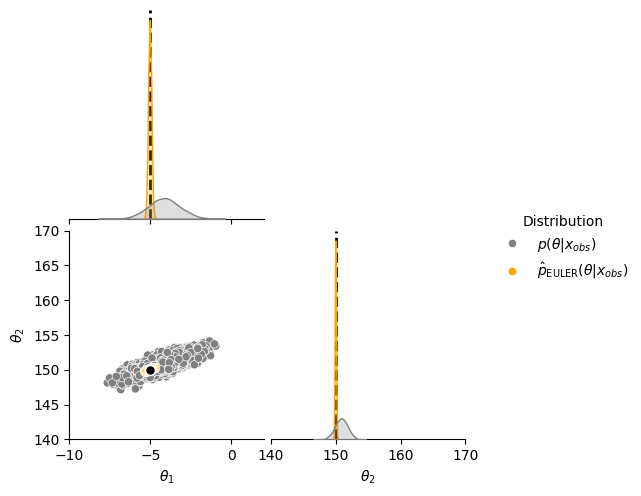

In [14]:
# analytic score

from functools import partial
score_fn = partial(diffused_tall_posterior_score, posterior_score_fn=None)
samples = euler_sde_sampler(score_fn, N_SAMPLES, beta=NSE(2,2).beta)

pairplot_with_groundtruth_2d(
    samples_list=[samples_true, samples],
    labels=[r"$p(\theta | x_{obs})$", r"$\hat{p}_\text{EULER}(\theta | x_{obs})$"],
    colors=["grey", "orange"],
    theta_true=theta_true,
    # prior_bounds=(prior.bounds[0], prior.bounds[1])
    plot_bounds=([-10, 2], [140, 170])
)

In [53]:
# Train data
theta_train = task.prior.sample((N_TRAIN,))
x_train = simulator(theta_train)

# normalize theta
theta_train_ = (theta_train - theta_train.mean(axis=0)) / theta_train.std(axis=0)

# normalize x
x_train_ = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)
x_obs_ = (x_obs - x_train.mean(axis=0)) / x_train.std(axis=0)
x_obs_100_ = (x_obs_100 - x_train.mean(axis=0)) / x_train.std(axis=0)

# score_network
from nse import NSE, NSELoss
from sm_utils import train

# torch.set_default_device("cuda:0")
dataset = torch.utils.data.TensorDataset(theta_train_.cuda(), x_train_.cuda())
score_net = NSE(theta_dim=2, x_dim=2, hidden_features=[128, 256, 128]).cuda()

avg_score_net = train(
    model=score_net,
    dataset=dataset,
    loss_fn=NSELoss(score_net),
    n_epochs=200,
    lr=1e-3,
    batch_size=256,
    prior_score=False, # learn the prior score via the classifier-free guidance approach
)
score_net = avg_score_net.module

Training epochs: 100%|██████████| 200/200 [00:48<00:00,  4.14it/s, loss=0.0411]


 10%|█         | 100/999 [00:08<01:16, 11.79it/s]

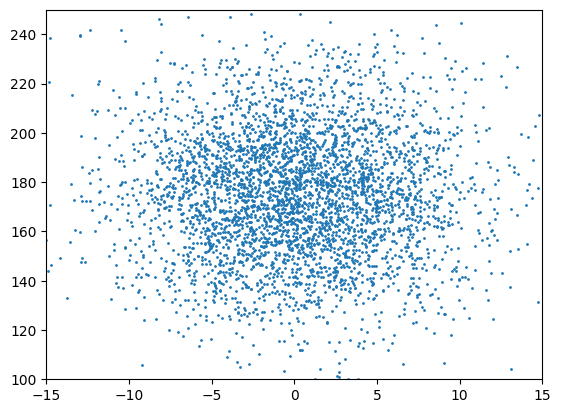

 50%|█████     | 500/999 [00:41<00:42, 11.67it/s]

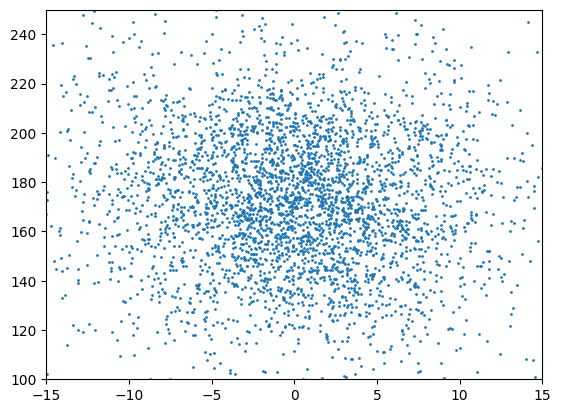

 70%|███████   | 700/999 [00:58<00:23, 12.63it/s]

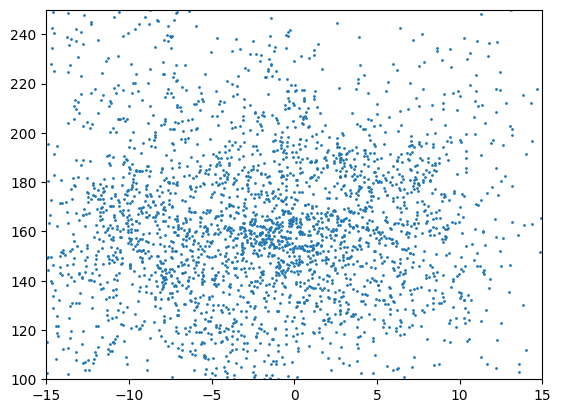

 90%|█████████ | 900/999 [01:14<00:07, 12.45it/s]

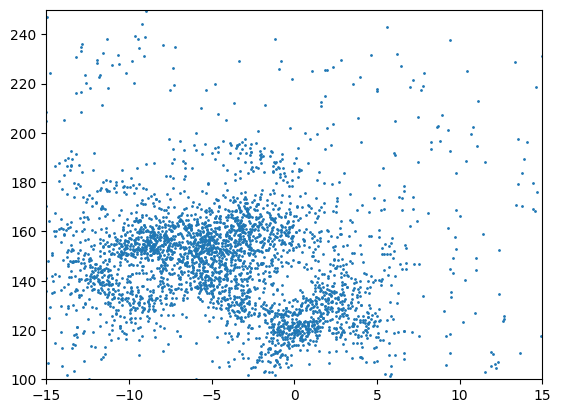

 95%|█████████▌| 950/999 [01:18<00:03, 13.24it/s]

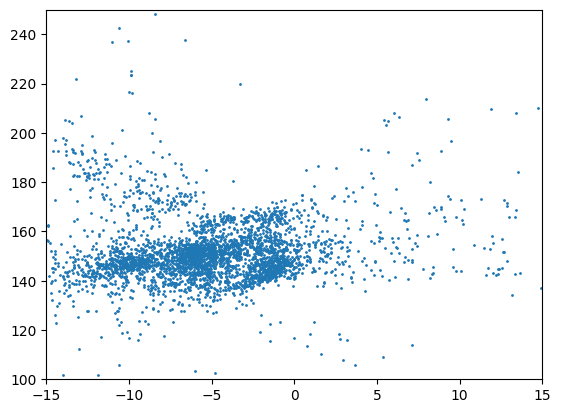

100%|█████████▉| 998/999 [01:23<00:00, 12.46it/s]

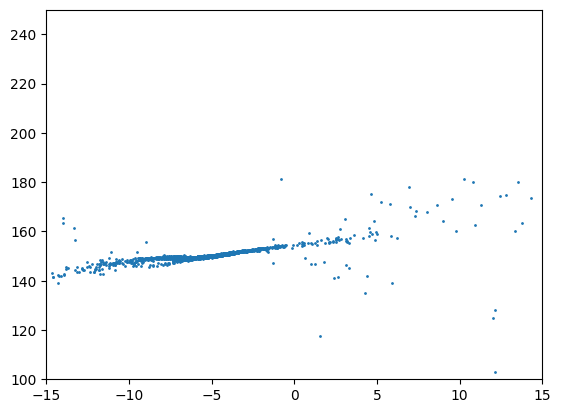

100%|██████████| 999/999 [01:23<00:00, 11.98it/s]


In [91]:
# sample with learned score 
from functools import partial
from vp_diffused_priors import get_vpdiff_gaussian_score
from tasks.toy_examples.prior import GaussianPrior

loc_ = prior.prior.loc - theta_train.mean(axis=0)
cov_ = prior.prior.covariance_matrix / theta_train.std(axis=0) ** 2

means = {0: loc_[0], 1: loc_[1]}

stds = {0: cov_[0][0]**.5, 1: cov_[1][1]**.5}

prior_ = GaussianPrior(means=means, stds=stds)
prior_score_fn = get_vpdiff_gaussian_score(loc_.cuda(), cov_.cuda(), nse=score_net)

score_fn = partial(diffused_tall_posterior_score, prior=prior_, prior_score_fn=prior_score_fn,posterior_score_fn=score_net.score, x_obs=x_obs_100_[:5])
samples = euler_sde_sampler(score_fn, N_SAMPLES, beta=NSE(2,2).beta, device="cuda:0", plot_idx=[100, 500, 700, 900, 950, 998], theta_mean=theta_train.mean(axis=0), theta_std=theta_train.std(axis=0))


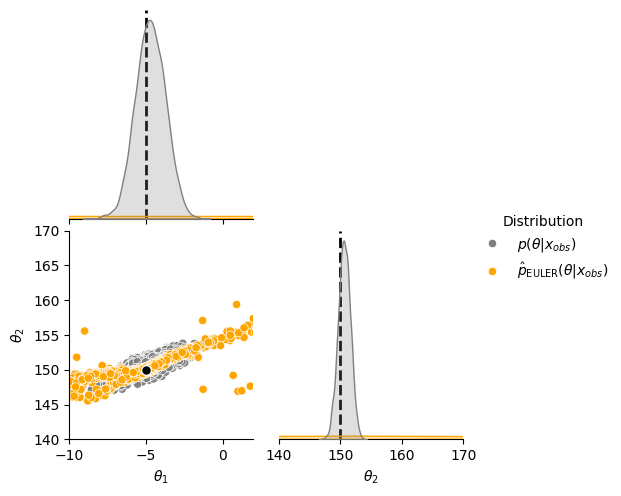

In [92]:
# unnormalize samples
samples = samples.detach().cpu() * theta_train.std(axis=0) + theta_train.mean(axis=0)

pairplot_with_groundtruth_2d(
    samples_list=[samples_true, samples],
    labels=[r"$p(\theta | x_{obs})$", r"$\hat{p}_\text{EULER}(\theta | x_{obs})$"],
    colors=["grey", "orange"],
    theta_true=theta_true,
    # prior_bounds=(prior.bounds[0], prior.bounds[1])
    plot_bounds=([-10, 2], [140, 170]),
)

## Posterior Estimation via Score-Matching
In what follows, the estimator will try to approximate the posterior $p(\theta \mid x_0) = \mathcal{N}(x_0, \Sigma)$ with samples from the joint $(x_i, \theta_i) \sim p(x\mid \theta_i)p(\theta_i)$ using score-matching.

See [[Sharrock et al. (2022)]](https://arxiv.org/abs/2210.04872).

### Data Generation

In [24]:
# Train data
theta_train = task.prior.sample((N_TRAIN,))
x_train = simulator(theta_train)

# normalize theta
theta_train_ = (theta_train - theta_train.mean(axis=0)) / theta_train.std(axis=0)

# normalize x
x_train_ = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)
x_obs_ = (x_obs - x_train.mean(axis=0)) / x_train.std(axis=0)
x_obs_100_ = (x_obs_100 - x_train.mean(axis=0)) / x_train.std(axis=0)


### Neural Posterior Score Estimation (NPSE)

Training the score model consists in minimizing the DSM loss, i.e. the expectation over the uniformly distributed time frame in $[0,T]$ of the weighted DSM losses. 
$$\mathcal{L}^{\mathrm{DSM}}(\phi) = \mathbb{E}_{\mathcal{U}(0,T)} \Big[\lambda_t \mathcal{L}^{\mathrm{DSM}_t}(p_t, \phi)\Big]$$

We are in a conditional case, the DSM losses depend on data from the joint distribution $p(\theta,x)$ and the score model $s_\phi(\theta,x,t)$ depends on the context varaible $x$, in addition to the target varaible $\theta$ and the time variable $t$: 

$$ \mathcal{L}^{\mathrm{DSM}_t}(p_t,\phi) = \mathbb{E}_{p_{t\mid0}(\theta(t)|\theta(0)), p(\theta(0),x)}\left[||s_{\phi}(\theta(t),x, t)-\nabla_\theta \log p_{t\mid0}(\theta(t)\mid \theta(0))||^2\right]$$

> Note that only the target variable $\theta$ is diffused via the SDE forward transition kernel $p_{t0}(\theta(t)\mid \theta(0))$ and $\theta(0) \sim p(\theta), x \sim p(x\mid \theta(0))$ are data from the joint.

#### Define and train Score Model

In [25]:
# score_network
from nse import NSE, NSELoss
from sm_utils import train

# torch.set_default_device("cuda:0")
dataset = torch.utils.data.TensorDataset(theta_train_.cuda(), x_train_.cuda())
score_net = NSE(theta_dim=2, x_dim=2, hidden_features=[128, 256, 128]).cuda()



In [26]:
avg_score_net = train(
    model=score_net,
    dataset=dataset,
    loss_fn=NSELoss(score_net),
    n_epochs=200,
    lr=1e-3,
    batch_size=256,
    prior_score=False, # learn the prior score via the classifier-free guidance approach
)
score_net = avg_score_net.module

Training epochs: 100%|██████████| 200/200 [00:45<00:00,  4.37it/s, loss=0.0447]


#### Sample from the approximate posterior

In [27]:
# sample from the appeoximate posterior
samples_npse = score_net.ddim((N_SAMPLES,), x=x_obs_.cuda(), steps=256).detach().cpu()
# unnormalize samples
samples_npse = samples_npse * theta_train.std(axis=0) + theta_train.mean(axis=0)

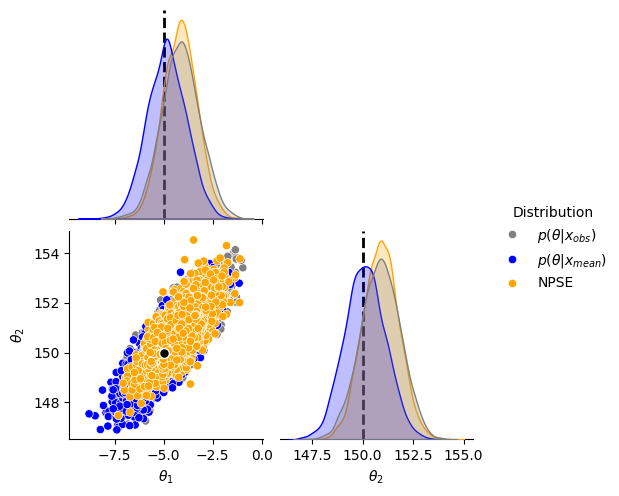

In [28]:
# Plot True vs. learned posteriors: P(theta | x_obs)
samples_list=[samples_true, samples_true_100, samples_npse]

pairplot_with_groundtruth_2d(
    samples_list=samples_list,
    labels=[r"$p(\theta | x_{obs})$", r"$p(\theta | x_{mean})$", "NPSE"],
    colors=["grey", "blue", "orange"],
    theta_true=theta_true
)


#### Aggregated score by Tweedie's

Below, we test replacing the F-NPSE score with our new version that incorporates the correction term L.


In [29]:
from vp_diffused_priors import get_vpdiff_gaussian_score

loc_ = prior.prior.loc - theta_train.mean(axis=0)
cov_ = prior.prior.covariance_matrix / theta_train.std(axis=0) ** 2

diffused_prior_score = get_vpdiff_gaussian_score(loc_.cuda(), cov_.cuda(), nse=score_net)

# try with learned prior score
# diffused_prior_score = lambda theta,t: score_net.score(theta=theta, x=torch.zeros_like(x_obs_100[:10]).cuda(), t=t)

In [75]:
# different n
samples_per_n = {}
for n_obs in [1,5,10]: # amount of correction term L in addition to the original F-NPSE
    samples_langevin_ = score_net.predictor_corrector((N_SAMPLES,),
                                                      x=x_obs_100_[:n_obs].cuda(),
                                                      steps=1000,
                                                      prior_score_fun=diffused_prior_score,
                                                      eta=1,
                                                      corrector_lda=1,
                                                      n_steps=0,
                                                      r=.5,
                                                      predictor_type='ddim',
                                                      verbose=True).cpu()
    samples_per_n[n_obs] = samples_langevin_ * theta_train.std(axis=0) + theta_train.mean(axis=0)

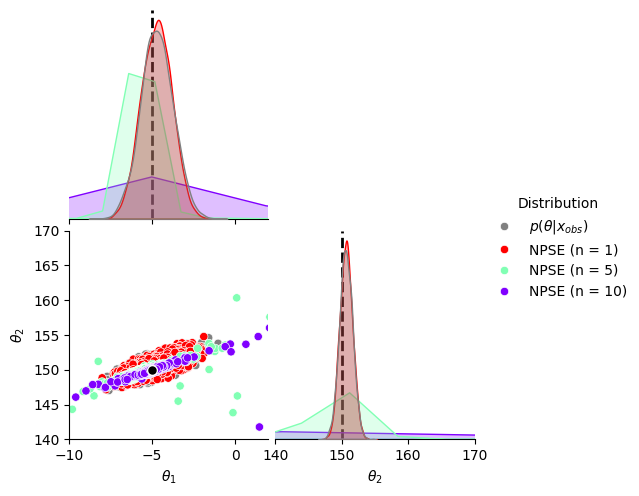

In [34]:
from matplotlib import colormaps as cm
samples_true = task.true_posterior(x_obs_100[0]).sample((N_SAMPLES,)).numpy()
pairplot_with_groundtruth_2d(
    samples_list=[samples_true] + list(samples_per_n.values()),
    labels=[r"$p(\theta | x_{obs})$"]+[f"NPSE (n = {k})" for k in samples_per_n],
    colors=["gray"] + [cm.get_cmap("rainbow")(i) for i in torch.linspace(1, 0, len(samples_per_n)).cpu()],
    theta_true=theta_true,
    # prior_bounds=(prior.bounds[0], prior.bounds[1]),
    plot_bounds=([-10, 2], [140, 170]),
)